# PROJETO DE SISTEMAS BASEADOS EM APRENDIZADO DE MÁQUINA

Projeto 01 - Problema de Regressão (Airbnb)

Aluna: Luciana Gouveia Machado







O código baixa um arquivo comprimido da internet e depois o descompacta, gerando um arquivo CSV pronto para ser usado, enquanto mantém o original compactado.


In [2]:
!pip install pandas torch matplotlib seaborn
# Use wget to download the dataset
!wget -O listings.csv.gz "https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2025-03-19/data/listings.csv.gz"

# Unzip the .gz file (-k keeps the original .gz file)
!gunzip -k listings.csv.gz

--2025-09-21 14:55:09--  https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2025-03-19/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... --2025-09-21 14:55:09--  https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2025-03-19/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 3.174.29.30, 3.174.29.63, 3.174.29.115, ...
Connecting to data.insideairbnb.com (data.insideairbnb.com)|3.174.29.30|:443... connected.
3.174.29.30, 3.174.29.63, 3.174.29.115, ...
Connecting to data.insideairbnb.com (data.insideairbnb.com)|3.174.29.30|:443... connected.
HTTP request sent, awaiting response... HTTP request sent, awaiting response... 200 OK
Length: 21857120 (21M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz       0%[                    ]       0  --.-KB/s               200 OK
Length: 21857120 (21M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]  20.84M  1.43MB/s   

In [3]:
# Robust tqdm import: prefer tqdm.auto to avoid notebook-specific AttributeError in tqdm.notebook.__del__
# Place this cell near the top (before any use of tqdm.notebook)
import importlib, sys
try:
    # tqdm.auto selects the best implementation for the environment (notebook/console)
    from tqdm.auto import tqdm
    print('Using tqdm.auto (recommended)')
except Exception as e:
    print('tqdm.auto import failed, falling back to tqdm:', e)
    try:
        from tqdm import tqdm
        print('Using tqdm (fallback)')
    except Exception as e2:
        print('tqdm import failed entirely:', e2)

# Informational: show versions to help debugging if problems persist
try:
    import tqdm
    print('tqdm version:', getattr(tqdm, '__version__', 'unknown'))
except Exception:
    pass
try:
    import ipywidgets as widgets
    print('ipywidgets version:', widgets.__version__)
except Exception:
    pass

# If you still see the AttributeError (tqdm_notebook has no attribute 'disp'), try upgrading tqdm to a newer release and restart the kernel:
#   pip install -U tqdm ipywidgets jupyterlab_widgets
# Then restart the kernel and re-run the notebook.

Using tqdm.auto (recommended)
tqdm version: 4.67.1
ipywidgets version: 8.1.7


In [4]:
# Instalador seguro para ipywidgets / tqdm + fallback amigável
# Tenta importar, se falhar tenta instalar no mesmo ambiente do kernel
import sys, subprocess, importlib
def try_install(pkgs):
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade'] + pkgs)
        return True
    except subprocess.CalledProcessError as e:
        print('pip install failed with error:', e)
        return False

# 1) Check ipywidgets
widgets_ok = False
try:
    import ipywidgets as widgets
    print('ipywidgets available, version', widgets.__version__)
    widgets_ok = True
except Exception as e:
    print('ipywidgets import failed:', e)
    print('Attempting to install ipywidgets and tqdm into the current Python environment...')
    ok = try_install(['ipywidgets', 'tqdm', 'jupyterlab_widgets'])
    if ok:
        try:
            import ipywidgets as widgets
            print('ipywidgets installed, version', widgets.__version__)
            widgets_ok = True
        except Exception as e2:
            print('Still cannot import ipywidgets after install:', e2)
            widgets_ok = False

# 2) Setup tqdm fallback (prefer notebook version when available)
try:
    from tqdm.notebook import tqdm
    print('Using tqdm.notebook')
except Exception as e:
    print('tqdm.notebook not available, using console tqdm -', e)
    from tqdm import tqdm

# 3) If ipywidgets still not OK, print next-steps for the user
if not widgets_ok:
    print('If ipywidgets failed to install, try one of the following:')
    print(' - In a terminal:')
    print()
    print()
    print(' - If you use conda:')
    print('     conda install -c conda-forge ipywidgets jupyterlab_widgets tqdm')
    print(' - If you are in Colab, try restarting the runtime after installing ipywidgets.')
    print('If none of those work, paste the full pip error here (traceback) and I will help diagnose.')

# 4) Quick sanity checks for JupyterLab versions (informational)
try:
    import jupyterlab
    print('jupyterlab version (if installed):', getattr(jupyterlab, '__version__', 'unknown'))
except Exception:
    pass

ipywidgets available, version 8.1.7
Using tqdm.notebook


jupyterlab version (if installed): 4.4.7


Esse trecho carrega o arquivo listings.csv no Pandas e trata os espaços excedentes que possam vir nas colunas.

**Modificação:**
Adicionei um tratamento de espaços vazios nas colunas.
``` python
df.columns = [c.strip() for c in df.columns]
```
No atual aparentemente não tem problema por que as colunas não tem espaços extras, mas com outro conjunto de dados pode dar problema.

In [5]:
# Now you have the "listings.csv" file available in Colab
import pandas as pd

pd.set_option('display.max_columns', None)

df = pd.read_csv("listings.csv")
df.columns = [c.strip() for c in df.columns]



**Modificação:**
Visando incluir outros fatores para que o algoritmo possa melhorar a predição do preço, peguei a coluna amenities e transformei ela em 3 colunas:
1) parking_free - tem algum estacionamento grátis
2) has_airconditioner - tem arcondicionado
3) pet_allowed - permite pet

Para isso foi criada a função parse_amenities. Em seguida desse tratamento é exibida uma visão geral dos dados.

In [6]:
import json, re

def parse_amenities(s):
    if not isinstance(s, str):
        return []
    s = s.strip()
    try:
        arr = json.loads(s)
        if isinstance(arr, list):
            return [str(x).lower() for x in arr]
    except Exception:
        # fallback simples: remove colchetes e separa por vírgula
        s2 = s.strip("[]{}")
        return [t.strip().strip('"').strip("'").lower() for t in s2.split(",") if t.strip()]
    return []

if 'amenities' in df.columns:
    am_tokens = df['amenities'].apply(parse_amenities)

    def has_parking_free(tokens):
        # cobre: free parking on premises, free street parking, free parking garage...
        return any(
            ('free parking' in t) or
            (t.startswith('free ') and 'parking' in t) or
            ('free street parking' in t)
            for t in tokens
        )

    def has_air_conditioning(tokens):
        rx = re.compile(r"\bair conditioning\b")
        return int(any(rx.search(t) for t in tokens))


    # ---- FLAGS ----
    df['parking_free'] = am_tokens.apply(has_parking_free).astype(int)
    df['amen_ac']      = am_tokens.apply(has_air_conditioning).astype(int)


    print("Features de amenities adicionadas (somas de 1s):")
    print(df[['parking_free','amen_ac']].sum())
else:
    print("Coluna 'amenities' não encontrada; pulando FE de amenities.")

Features de amenities adicionadas (somas de 1s):
parking_free    18528
amen_ac         26199
dtype: int64


Exibe um resumo estrutural do DataFrame (colunas, tipos de dados e valores não nulos).

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42013 entries, 0 to 42012
Data columns (total 81 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            42013 non-null  int64  
 1   listing_url                                   42013 non-null  object 
 2   scrape_id                                     42013 non-null  int64  
 3   last_scraped                                  42013 non-null  object 
 4   source                                        42013 non-null  object 
 5   name                                          42013 non-null  object 
 6   description                                   40982 non-null  object 
 7   neighborhood_overview                         16819 non-null  object 
 8   picture_url                                   42013 non-null  object 
 9   host_id                                       42013 non-null 

Gera um resumo estatístico das colunas numéricas do DataFrame, mostrando contagem, média, desvio padrão, valores mínimo, quartis e máximo.

In [8]:
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,parking_free,amen_ac
count,42013.00,42013.00,42013.00,42008.00,42008.00,0.00,42013.00,42013.00,42013.00,38313.00,41373.00,38335.00,42013.00,42013.00,42013.00,42013.00,42013.00,42013.00,42013.00,42013.00,0.00,42013.00,42013.00,42013.00,42013.00,42013.00,42013.00,42013.00,42013.00,42013.00,42013.00,38356.00,33140.00,33139.00,33140.00,33139.00,33139.00,33139.00,33139.00,0.00,42013.00,42013.00,42013.00,42013.00,33140.00,42013.00,42013.00
mean,744470976674007552.00,20250319150537.00,225605229.07,14.05,24.93,NaN,-22.97,-43.25,3.96,1.50,1.52,2.36,3.61,366.08,3.34,4.21,452.46,480.01,3.65,463.65,NaN,17.36,36.68,59.12,188.78,23.68,8.11,0.98,161.19,6.99,49.72,20769.35,4.80,4.82,4.77,4.89,4.88,4.86,4.72,NaN,9.34,8.45,0.78,0.11,1.26,0.44,0.62
std,539170547913701440.00,0.00,210343158.05,65.17,141.33,NaN,0.04,0.10,2.27,0.97,1.02,2.12,14.25,379.76,12.61,14.46,428.46,436.57,12.93,426.92,NaN,11.40,21.05,30.76,128.67,45.88,12.48,1.39,101.94,12.10,69.01,58033.71,0.39,0.38,0.42,0.31,0.32,0.32,0.43,NaN,24.43,24.24,2.13,1.19,1.28,0.50,0.48
min,17878.00,20250319150537.00,3607.00,1.00,1.00,NaN,-23.07,-43.72,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,1.00,0.00,0.00,0.00,0.01,0.00,0.00
25%,46258303.00,20250319150537.00,35000597.00,1.00,1.00,NaN,-22.98,-43.30,2.00,1.00,1.00,1.00,1.00,45.00,1.00,2.00,80.00,89.00,1.50,89.00,NaN,6.00,19.00,39.00,76.00,1.00,0.00,0.00,72.00,0.00,0.00,0.00,4.76,4.79,4.71,4.89,4.89,4.84,4.66,NaN,1.00,1.00,0.00,0.00,0.32,0.00,0.00
50%,949456535223262080.00,20250319150537.00,150144948.00,2.00,3.00,NaN,-22.97,-43.19,4.00,1.00,1.00,2.00,2.00,365.00,2.00,3.00,365.00,365.00,2.00,365.00,NaN,20.00,42.00,70.00,173.00,6.00,2.00,0.00,167.00,1.00,18.00,6156.00,4.92,4.93,4.90,5.00,5.00,4.96,4.83,NaN,2.00,1.00,0.00,0.00,0.93,0.00,1.00
75%,1236131635648997120.00,20250319150537.00,414963533.00,6.00,9.00,NaN,-22.95,-43.18,5.00,2.00,2.00,3.00,3.00,365.00,3.00,4.00,1125.00,1125.00,3.00,1125.00,NaN,29.00,56.00,86.00,329.00,26.00,11.00,2.00,268.00,9.00,72.00,24160.50,5.00,5.00,5.00,5.00,5.00,5.00,5.00,NaN,5.00,4.00,1.00,0.00,1.86,1.00,1.00
max,1379823621006622720.00,20250319150537.00,684805701.00,3232.00,8646.00,NaN,-22.75,-43.10,16.00,20.00,30.00,56.00,1000.00,1125.00,730.00,1125.00,1125.00,1125.00,730.00,1125.00,NaN,30.00,60.00,90.00,365.00,726.00,161.00,18.00,288.00,154.00,255.00,5405400.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,NaN,214.00,214.00,28.00,25.00,13.65,1.00,1.00


Esse trecho seleciona apenas colunas específicas do df, cria um novo DataFrame chamado rio_listings com esses dados e mostra 5 linhas aleatórias para conferência.

**Modificado:** Adiciona as 03 colunas especificadas acima.

In [9]:
# Select only the relevant columns from the original dataframe 'df'
# These columns include property features (e.g., accommodates, bathrooms, bedrooms)
# and booking information (e.g., minimum_nights, maximum_nights, number_of_reviews, price).

target_columns = [
    "accommodates",      # Number of guests the property can host
    "bathrooms",         # Number of bathrooms available
    "bedrooms",          # Number of bedrooms available
    "beds",              # Number of beds available
    "minimum_nights",    # Minimum nights required for a booking
    "maximum_nights",    # Maximum nights allowed for a booking
    "number_of_reviews", # Total reviews given by past guests
    "parking_free",      # Has parking free
    "amen_ac",           # Has air conditioner
    "price"              # Nightly rental price
]

# Create a new dataframe called 'rio_listings' with only the selected columns
# Using .copy() ensures that we are working with an independent dataframe
# instead of just a view of the original data.

rio_listings = df[target_columns].copy()

# Display a five rows sample of the new dataframe to quickly check the data
rio_listings.sample(5)

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,parking_free,amen_ac,price
2708,4,2.50,2.00,3.00,4,1125,1,1,1,"$5,664.00"
5779,5,1.00,2.00,1.00,1,1125,0,0,1,"$1,000.00"
35154,4,1.00,1.00,1.00,4,10,1,0,1,$765.00
11251,2,1.00,1.00,1.00,3,5,0,1,0,$500.00
23492,4,NaN,2.00,NaN,1,365,1,0,0,NaN


# Clean, Prepare & Manipulate Data

Esse comando gera estatísticas descritivas (contagem, média, desvio padrão, mínimos, quartis e máximos) para as colunas numéricas do DataFrame rio_listings.

In [10]:
# Generate descriptive statistics
rio_listings.describe()

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,parking_free,amen_ac
count,42013.00,38313.00,41373.00,38335.00,42013.00,42013.00,42013.00,42013.00,42013.00
mean,3.96,1.50,1.52,2.36,3.61,366.08,23.68,0.44,0.62
std,2.27,0.97,1.02,2.12,14.25,379.76,45.88,0.50,0.48
min,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,2.00,1.00,1.00,1.00,1.00,45.00,1.00,0.00,0.00
50%,4.00,1.00,1.00,2.00,2.00,365.00,6.00,0.00,1.00
75%,5.00,2.00,2.00,3.00,3.00,365.00,26.00,1.00,1.00
max,16.00,20.00,30.00,56.00,1000.00,1125.00,726.00,1.00,1.00


Esse comando mostra um resumo do rio_listings, incluindo quantos valores não nulos cada coluna tem — útil para identificar dados ausentes.

In [11]:
# Check missing values
rio_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42013 entries, 0 to 42012
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       42013 non-null  int64  
 1   bathrooms          38313 non-null  float64
 2   bedrooms           41373 non-null  float64
 3   beds               38335 non-null  float64
 4   minimum_nights     42013 non-null  int64  
 5   maximum_nights     42013 non-null  int64  
 6   number_of_reviews  42013 non-null  int64  
 7   parking_free       42013 non-null  int64  
 8   amen_ac            42013 non-null  int64  
 9   price              38356 non-null  object 
dtypes: float64(3), int64(6), object(1)
memory usage: 3.2+ MB


Esse código limpa os valores da coluna price, retirando vírgulas e símbolos de dólar e convertendo os dados para números (float), deixando a coluna pronta para análises.


In [12]:
# Remove commas from the 'price' column (e.g., "$1,200" → "$1200")
stripped_commas = rio_listings['price'].str.replace(',', '')

# Remove dollar signs from the 'price' column (e.g., "$1200" → "1200")
stripped_dollars = stripped_commas.str.replace('$', '')

# Convert the cleaned 'price' column from string to float type
rio_listings['price'] = stripped_dollars.astype('float')

Esse comando remove todas as linhas do rio_listings que contêm valores ausentes em qualquer uma das colunas selecionadas.

In [13]:
# Remove any rows containing missing values across the selected columns
rio_listings.dropna(axis=0, inplace=True)

Esse comando exibe novamente o resumo do rio_listings após a limpeza, mostrando quantas linhas e colunas restaram e se ainda existem valores ausentes.

In [14]:
# Check missing values
rio_listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38242 entries, 0 to 42012
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       38242 non-null  int64  
 1   bathrooms          38242 non-null  float64
 2   bedrooms           38242 non-null  float64
 3   beds               38242 non-null  float64
 4   minimum_nights     38242 non-null  int64  
 5   maximum_nights     38242 non-null  int64  
 6   number_of_reviews  38242 non-null  int64  
 7   parking_free       38242 non-null  int64  
 8   amen_ac            38242 non-null  int64  
 9   price              38242 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 3.2 MB


## Robust IQR-based outlier filtering

“Filtragem robusta de outliers baseada no IQR (Intervalo Interquartil)"

Esse código implementa uma forma robusta de tratar outliers: ele calcula os limites inferior e superior pelo método do IQR (Intervalo Interquartil) e remove, das colunas indicadas do DataFrame, as linhas cujos valores estão fora desses limites.

In [15]:
def _iqr_bounds(series: pd.Series, k: float = 1.5):
    """
    Compute lower/upper bounds for outlier detection using the IQR rule.

    Parameters
    ----------
    series : pd.Series
        Numeric series.
    k : float, default 1.5
        Whisker length multiplier (1.5 = Tukey; 3.0 = more tolerant).

    Returns
    -------
    low : float
        Lower bound (Q1 - k * IQR).
    up : float
        Upper bound (Q3 + k * IQR).
    stats : dict
        Dict with Q1, Q3, IQR.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    up = q3 + k * iqr
    return low, up, {"Q1": q1, "Q3": q3, "IQR": iqr}


def remove_outliers_iqr(
    df: pd.DataFrame,
    columns: list[str],
    k: float = 1.5,
    inclusive: bool = True,
    dropna: bool = True,
):
    """
    Remove rows with outliers per-column using the IQR rule.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    columns : list of str
        Columns to evaluate for outliers (must be numeric or coercible).
    k : float, default 1.5
        Whisker length multiplier (1.5 = standard; 3.0 = lenient).
    inclusive : bool, default True
        If True, keep values exactly on the bounds; otherwise use strict inequality.
    dropna : bool, default True
        If True, drop rows with NaN in the selected columns prior to filtering.

    Returns
    -------
    cleaned : pd.DataFrame
        DataFrame with outlier rows removed.
    info : dict
        Summary with input/output row counts and per-column bounds/statistics.
    """
    data = df.copy()

    # Ensure columns are numeric; non-numeric values become NaN
    for c in columns:
        data[c] = pd.to_numeric(data[c], errors="coerce")

    # Optionally drop NaNs first to avoid excluding entire rows by comparison
    if dropna:
        data = data.dropna(subset=columns)

    before = len(data)
    bounds = {}
    # Start with all rows valid; refine with each column's mask
    mask = pd.Series(True, index=data.index)

    for c in columns:
        low, up, stats = _iqr_bounds(data[c].dropna(), k=k)
        bounds[c] = {"low": low, "up": up, **stats}

        if inclusive:
            m = (data[c] >= low) & (data[c] <= up)
        else:
            m = (data[c] > low) & (data[c] < up)

        mask &= m

    cleaned = data.loc[mask].copy()
    info = {
        "rows_in": before,
        "rows_out": len(cleaned),
        "rows_removed": before - len(cleaned),
        "k": k,
        "inclusive": inclusive,
        "bounds": bounds,
    }
    return cleaned, info

Esse bloco copia o subconjunto rio_listings, aplica a remoção de outliers via IQR (regra de Tukey, k=1.5, limites inclusivos) em todas as colunas alvo, e depois reporta quantas linhas havia antes/depois, quantas foram removidas e os limites/estatísticas (Q1, Q3, IQR) por coluna; por fim, mostra as primeiras linhas do DataFrame filtrado (rio_iqr.head()).

In [16]:
# Assumes you already have:
# - df (your full dataset)
# - target_columns = ["accommodates","bathrooms","bedrooms","beds","minimum_nights",
#                     "maximum_nights","number_of_reviews","price"]
# - rio_listings = df[target_columns].copy()   # your prepared subset

# Copy the dataset to work on IQR filtering
rio_iqr_input = rio_listings[target_columns].copy()

# Remove outliers with default Tukey rule (k=1.5) and inclusive bounds
rio_iqr, summary = remove_outliers_iqr(
    df=rio_iqr_input,
    columns=target_columns,
    k=1.5,
    inclusive=True,
    dropna=True,
)

print(f"Rows before:  {summary['rows_in']}")
print(f"Rows after:   {summary['rows_out']}")
print(f"Removed:      {summary['rows_removed']}")
print("Per-column bounds (low/up):")
for col, b in summary["bounds"].items():
    print(f"  - {col}: [{b['low']:.3f}, {b['up']:.3f}]  (Q1={b['Q1']:.3f}, Q3={b['Q3']:.3f}, IQR={b['IQR']:.3f})")

rio_iqr.head()

Rows before:  38242
Rows after:   23715
Removed:      14527
Per-column bounds (low/up):
  - accommodates: [-2.500, 9.500]  (Q1=2.000, Q3=5.000, IQR=3.000)
  - bathrooms: [-0.500, 3.500]  (Q1=1.000, Q3=2.000, IQR=1.000)
  - bedrooms: [-0.500, 3.500]  (Q1=1.000, Q3=2.000, IQR=1.000)
  - beds: [-2.000, 6.000]  (Q1=1.000, Q3=3.000, IQR=2.000)
  - minimum_nights: [-2.000, 6.000]  (Q1=1.000, Q3=3.000, IQR=2.000)
  - maximum_nights: [-397.500, 822.500]  (Q1=60.000, Q3=365.000, IQR=305.000)
  - number_of_reviews: [-38.000, 66.000]  (Q1=1.000, Q3=27.000, IQR=26.000)
  - parking_free: [-1.500, 2.500]  (Q1=0.000, Q3=1.000, IQR=1.000)
  - amen_ac: [-1.500, 2.500]  (Q1=0.000, Q3=1.000, IQR=1.000)
  - price: [-350.000, 1170.000]  (Q1=220.000, Q3=600.000, IQR=380.000)


,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,number_of_reviews,parking_free,amen_ac,price
2,7,2.00,3.00,6.00,5,90,13,0,1,800.00
4,4,1.00,1.00,2.00,2,28,28,1,1,220.00
5,2,1.00,1.00,1.00,2,730,36,1,1,401.00
7,4,2.00,2.00,2.00,3,30,38,1,0,399.00
8,4,1.00,1.00,2.00,4,90,3,0,1,198.00


Esse comando mostra um resumo estatístico (contagem, média, desvio padrão, valores mínimo, quartis e máximo) apenas da coluna price do DataFrame rio_iqr (já filtrado pelos outliers).

In [17]:
rio_iqr.price.describe()

count   23715.00
mean      380.57
std       232.80
min        41.00
25%       210.00
50%       311.00
75%       495.00
max      1170.00
Name: price, dtype: float64

## Correlation Heatmap of Rio Listings Features

“Mapa de calor de correlação das características dos anúncios do Rio”

Esse código calcula a matriz de correlação de Pearson para todas as variáveis do rio_iqr e mostra, em ordem decrescente, como cada feature se relaciona com o preço, ajudando a identificar as mais influentes na previsão.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute pairwise correlation matrix using Pearson's correlation coefficient
corr_matrix = rio_iqr.corr(method="pearson")

# Display features sorted by correlation strength with the target ('price')
# This helps identify which features are most relevant to predict 'price'
price_corr = corr_matrix["price"].sort_values(ascending=False)

print("Correlation of features with target 'price':\n")
print(price_corr)

Correlation of features with target 'price':

price                1.00
bedrooms             0.42
bathrooms            0.38
accommodates         0.38
beds                 0.29
minimum_nights       0.17
amen_ac              0.13
parking_free         0.10
maximum_nights      -0.05
number_of_reviews   -0.10
Name: price, dtype: float64


Cria uma visualização clara das relações entre as variáveis e o preço.

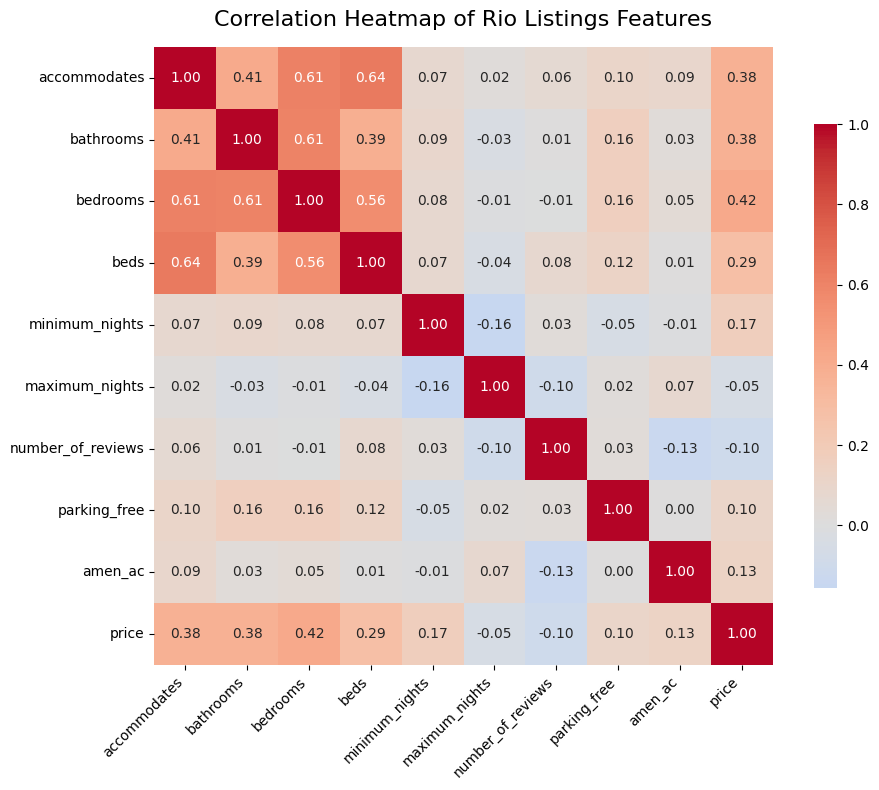

In [19]:
# Visualize correlation matrix

plt.figure(figsize=(10, 8))

sns.heatmap(
    corr_matrix,
    annot=True,          # show correlation values
    fmt=".2f",           # format with 2 decimals
    cmap="coolwarm",     # colormap: negative=blue, positive=red
    center=0,            # center color scale at 0
    square=True,         # square cells
    cbar_kws={"shrink": 0.75}  # adjust colorbar size
)

# Add a title to the heatmap
plt.title("Correlation Heatmap of Rio Listings Features", fontsize=16, pad=15)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Gráficos Box Plot - relação de preço

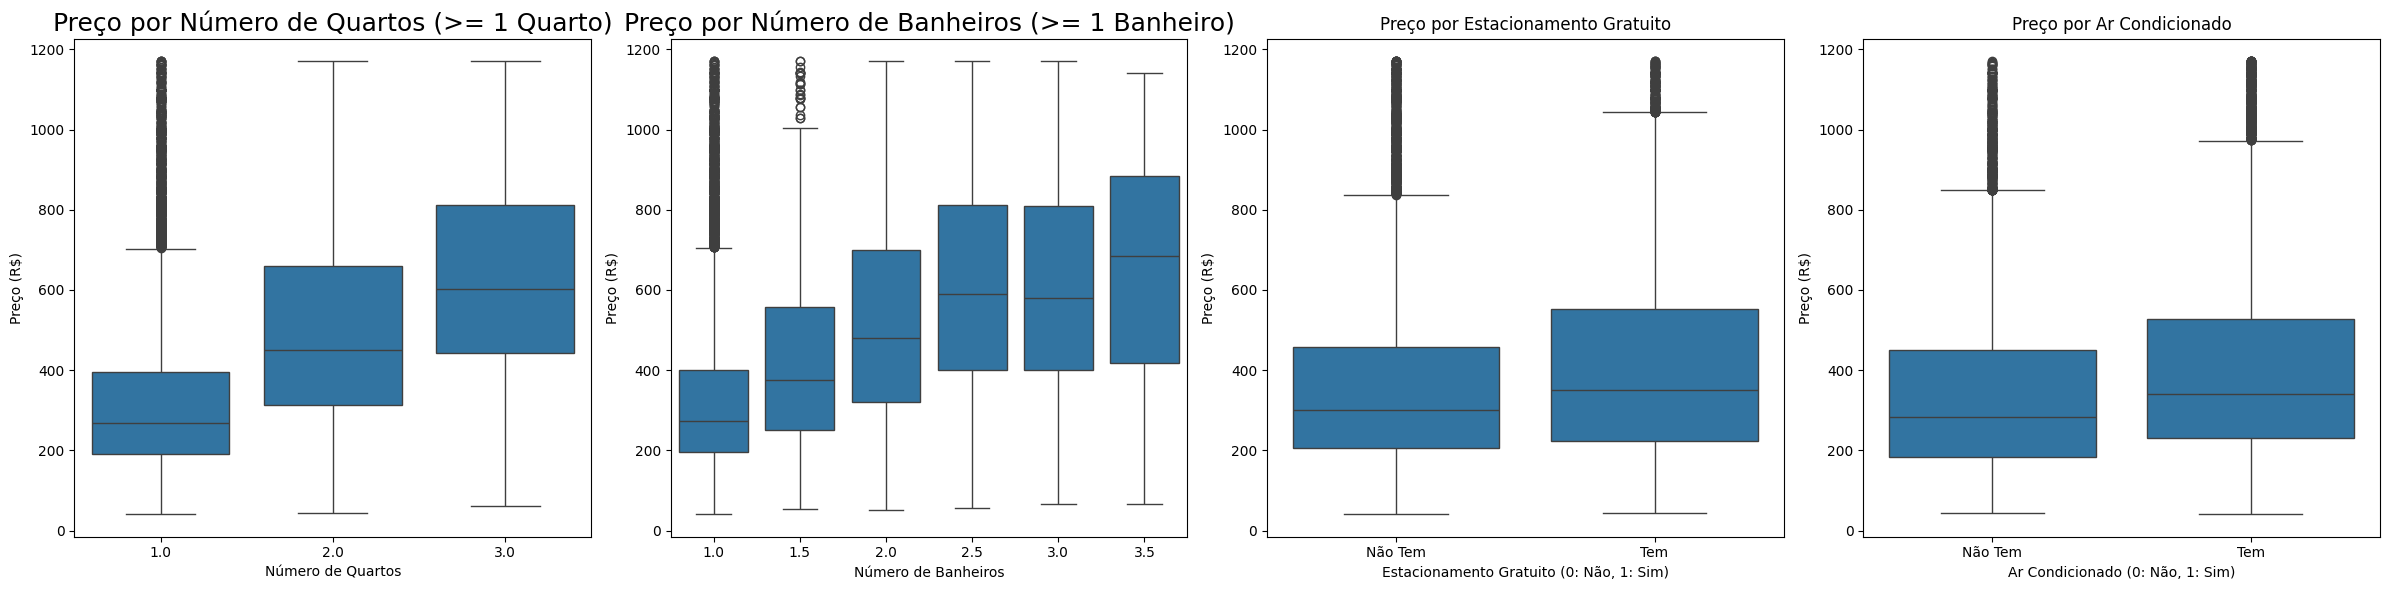

In [20]:
filtered_rio_iqr = rio_iqr[(rio_iqr['bedrooms'] >= 1.0) & (rio_iqr['bathrooms'] >= 1.0)].copy()

# Criar box plots para price vs bedrooms, price vs bathrooms, price vs parking_free, e price vs amen_ac
plt.figure(figsize=(24, 6)) # Increased figure size to accommodate the fourth plot

# Box plot para price por bedrooms (dados filtrados)
plt.subplot(1, 4, 1) # Changed to 1 row, 4 columns
sns.boxplot(x='bedrooms', y='price', data=filtered_rio_iqr)
plt.title('Preço por Número de Quartos (>= 1 Quarto)', fontsize=18)
plt.xlabel('Número de Quartos')
plt.ylabel('Preço (R$)')
#plt.xticks(rotation=45, ha='right') # Rotate x-axis labels

# Box plot para price por bathrooms (dados filtrados)
plt.subplot(1, 4, 2) # Changed to 1 row, 4 columns
sns.boxplot(x='bathrooms', y='price', data=filtered_rio_iqr)
plt.title('Preço por Número de Banheiros (>= 1 Banheiro)', fontsize=18)
plt.xlabel('Número de Banheiros')
plt.ylabel('Preço (R$)')
#plt.xticks(rotation=45, ha='right') # Rotate x-axis labels

# box plot para price por parking_free (dados filtrados)
plt.subplot(1, 4, 3) # Changed to 1 row, 4 columns
sns.boxplot(x='parking_free', y='price', data=filtered_rio_iqr)
plt.title('Preço por Estacionamento Gratuito')
plt.xlabel('Estacionamento Gratuito (0: Não, 1: Sim)')
plt.ylabel('Preço (R$)')
plt.xticks(ticks=[0, 1], labels=['Não Tem', 'Tem']) # Rotate x-axis labels

# Box plot para price por amen_ac (dados filtrados)
plt.subplot(1, 4, 4) # Added the fourth subplot
sns.boxplot(x='amen_ac', y='price', data=filtered_rio_iqr)
plt.title('Preço por Ar Condicionado')
plt.xlabel('Ar Condicionado (0: Não, 1: Sim)')
plt.ylabel('Preço (R$)')
plt.xticks(ticks=[0, 1], labels=['Não Tem', 'Tem'])


plt.tight_layout()
plt.show()

# End-to-End Solution Pipeline in PyTorch

“Pipeline de solução ponta a ponta em PyTorch”

## Import

Esse código importa as bibliotecas necessárias para manipular dados, criar e treinar modelos no PyTorch, dividir conjuntos de dados, otimizar redes neurais e gerar gráficos, além de definir o estilo visual das figuras.

In [21]:
import numpy as np
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
%matplotlib inline
plt.style.use('fivethirtyeight')

## Architecture class

Essa classe encapsula o treinamento, validação, salvamento, predição e visualização das perdas de um modelo PyTorch de forma prática e organizada.

In [22]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

## Data Preparation

Exibe um resumo estrutural do DataFrame após a filtragem de outliers.

In [23]:
rio_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23715 entries, 2 to 42012
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       23715 non-null  int64  
 1   bathrooms          23715 non-null  float64
 2   bedrooms           23715 non-null  float64
 3   beds               23715 non-null  float64
 4   minimum_nights     23715 non-null  int64  
 5   maximum_nights     23715 non-null  int64  
 6   number_of_reviews  23715 non-null  int64  
 7   parking_free       23715 non-null  int64  
 8   amen_ac            23715 non-null  int64  
 9   price              23715 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 2.0 MB


Prepara X (features) e y (alvo) para alimentar o modelo.

In [24]:
# ---------------------------------------------------------------------
# 1) Extract features (X) and target (y) from the DataFrame
# ---------------------------------------------------------------------

# Keep all numeric feature columns except the target 'price'
feature_cols = [c for c in rio_iqr.columns if c != "price"]
target_col   = "price"

# Convert to NumPy arrays (float32 is ideal for PyTorch)
X = rio_iqr[feature_cols].to_numpy(dtype=np.float32)     # shape (N, D)
y = rio_iqr[target_col].to_numpy(dtype=np.float32).reshape(-1, 1)  # shape (N, 1)

# Quick sanity checks
assert not np.isnan(X).any(), "Found NaNs in X. Clean/impute before training."
assert not np.isnan(y).any(), "Found NaNs in y. Clean/impute before training."

cria um conjunto de dados PyTorch completo, pronto para ser dividido em treino e validação ou alimentado diretamente em um DataLoader.

In [25]:
# ---------------------------------------------------------------------
# 2) Build tensors BEFORE splitting (as you requested)
# ---------------------------------------------------------------------

torch.manual_seed(13)

x_tensor = torch.as_tensor(X).float()   # (N, D)
y_tensor = torch.as_tensor(y).float()   # (N, 1)

# Whole dataset
dataset = TensorDataset(x_tensor, y_tensor)

Usa o random_split do PyTorch para fazer a divisão de forma aleatória, garantindo dados separados para treino e teste.

In [26]:
# ---------------------------------------------------------------------
# 3) Train/validation split using PyTorch's random_split
# ---------------------------------------------------------------------
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val   = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

Esse comando retorna o tipo do objeto train_data.
No caso do código acima, ele é um torch.utils.data.dataset.Subset, ou seja, um subconjunto do TensorDataset original (os dados de treino).

In [27]:
type(train_data)

torch.utils.data.dataset.Subset

Esse comando também retorna o tipo do objeto val_data.
Assim como train_data, ele é um torch.utils.data.dataset.Subset, ou seja, um subconjunto do TensorDataset original (os dados de validação).

In [28]:
type(val_data)

torch.utils.data.dataset.Subset

Padroniza os dados (média 0, desvio 1) com base no treino e reaplica isso ao conjunto completo, preservando o split.

In [29]:
# ---------------------------------------------------------------------
# Z-score without leakage
# ---------------------------------------------------------------------
from torch.utils.data import Subset

# 0) Get split indices produced by random_split (already done above)
train_idx = train_data.indices
val_idx   = val_data.indices

# 1) Compute mean/std ONLY on training subset
eps = 1e-8
mu  = x_tensor[train_idx].mean(dim=0)
std = x_tensor[train_idx].std(dim=0, unbiased=False)
std = torch.where(std < eps, torch.ones_like(std), std)  # avoid divide-by-zero

y_mu  = y_tensor[train_idx].mean(dim=0)
y_std = y_tensor[train_idx].std(dim=0, unbiased=False)
y_std = torch.where(y_std < eps, torch.ones_like(y_std), y_std)


# 2) Apply z-score to ALL features using training stats
x_tensor_z = (x_tensor - mu) / std
y_tensor_z = (y_tensor - y_mu) / y_std


# 3) Rebuild dataset with normalized features and REUSE the SAME indices
dataset_z  = TensorDataset(x_tensor_z, y_tensor_z)
train_data = Subset(dataset_z, train_idx)
val_data   = Subset(dataset_z, val_idx)

Prepara os carregadores de dados (DataLoaders) para treino e validação com batchs definidos.

In [30]:
# 4) Recreate the DataLoaders
batch_size  = 16
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset=val_data,   batch_size=batch_size, shuffle=False)

# Quick peek to confirm shapes
xb, yb = next(iter(train_loader))
print(f"Train batch X: {xb.shape} | y: {yb.shape}")  # e.g., (16, D) and (16, 1)

Train batch X: torch.Size([16, 9]) | y: torch.Size([16, 1])


## Model Configuration

Configura um modelo linear de regressão no PyTorch com otimização SGD e perda MSE.

**Modificação:** Otimizador Adam

In [31]:
# 5) (Optional but safer) Make model input dimension dynamic
# Sets learning rate
lr = 0.001
torch.manual_seed(42)
D = x_tensor.shape[1]  # number of features
model = nn.Sequential(nn.Linear(D, 1))
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

## Training

Inicia e executa todo o processo de treinamento do modelo.

In [32]:
n_epochs = 100
arch = Architecture(model, loss_fn, optimizer)
arch.set_seed(42)
arch.set_loaders(train_loader, val_loader)
arch.train(n_epochs=n_epochs)

Plota a curva de aprendizado, mostrando se o modelo está convergindo bem durante o treino.

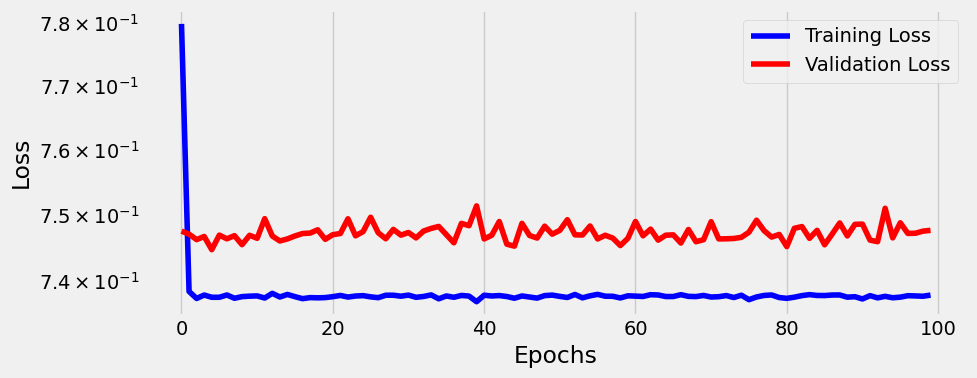

In [ ]:
dfig = arch.plot_losses()

Exibe um panorama estrutural atualizado do DataFrame filtrado.

In [34]:
rio_iqr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23715 entries, 2 to 42012
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   accommodates       23715 non-null  int64  
 1   bathrooms          23715 non-null  float64
 2   bedrooms           23715 non-null  float64
 3   beds               23715 non-null  float64
 4   minimum_nights     23715 non-null  int64  
 5   maximum_nights     23715 non-null  int64  
 6   number_of_reviews  23715 non-null  int64  
 7   parking_free       23715 non-null  int64  
 8   amen_ac            23715 non-null  int64  
 9   price              23715 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 2.0 MB


mostra como normalizar, predizer e reverter a normalização para obter o valor real previsto.

In [35]:
# -------------------------------------------------------------
# Suppose you trained and still have mu, std (for X) and y_mu, y_std (for y)
# -------------------------------------------------------------
# Example: one new sample with 12 features (same order as feature_cols)
# The order of features should match the order in feature_cols:
# accommodates, bathrooms, bedrooms, beds, minimum_nights, maximum_nights, number_of_reviews, parking_free, amen_ac
X_new = np.array([[2.0, 1.0, 2.0, 2.0, 4.0, 100.0, 30.0, 1.0, 1.0]], dtype=np.float32)
# (this is just a made-up input)

# -------------------------------------------------------------
# 1) Apply the SAME feature normalization (z-score using training mu/std)
# -------------------------------------------------------------
X_new_t = torch.as_tensor(X_new)
X_new_norm = (X_new_t - mu) / std  # mu, std from TRAIN only

# -------------------------------------------------------------
# 2) Predict with your trained Architecture
# -------------------------------------------------------------
y_pred_z = arch.predict(X_new_norm.numpy())   # prediction in standardized space of y

# -------------------------------------------------------------
# 3) Revert target normalization back to original units
# -------------------------------------------------------------
y_pred_real = y_pred_z * y_std.item() + y_mu.item()

# Convert to scalar
y_pred_real_value = float(y_pred_real.squeeze())

print(f"Predicted price: R$ {y_pred_real_value:.2f}")

Predicted price: R$ 420.66


# Comparação LazyPredict

In [36]:
!pip install lazyPredict

In [37]:
# ---------------------------------------------------------------------
# 1) Extract features (X) and target (y) from the DataFrame
# ---------------------------------------------------------------------

# Keep all numeric feature columns except the target 'price'
feature_cols = [c for c in rio_iqr.columns if c != "price"]
target_col   = "price"

# Convert to NumPy arrays (float32 is ideal for PyTorch)
X = rio_iqr[feature_cols].to_numpy(dtype=np.float32)     # shape (N, D)
y = rio_iqr[target_col].to_numpy(dtype=np.float32).reshape(-1, 1)  # shape (N, 1)

# Quick sanity checks
assert not np.isnan(X).any(), "Found NaNs in X. Clean/impute before training."
assert not np.isnan(y).any(), "Found NaNs in y. Clean/impute before training."

## Esta seção aborda um comparativo para o Lazypredict


In [39]:
# --- Comparação "Architecture usando ADAM" x LazyPredict  ---
# Note: install lazypredict in your environment beforehand if needed (pip install lazypredict)
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1) Reconstruct X/y from the already pre-processed dataframe ---
feature_cols = [c for c in rio_iqr.columns if c != 'price']
X = rio_iqr[feature_cols].to_numpy(dtype=np.float32)
y = rio_iqr['price'].to_numpy(dtype=np.float32).ravel()
X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[val_idx]
y_val = y[val_idx]

# --- 2) Try running LazyPredict safely ---
lazy_rows = []
try:
    from lazypredict.Supervised import LazyRegressor
    reg = LazyRegressor(ignore_warnings=True, verbose=0)
    models_df, predictions = reg.fit(X_train, X_val, y_train, y_val)
    # predictions: DataFrame with shape (n_samples, n_models) or Series-like mapping
    if isinstance(predictions, pd.DataFrame):
        # columns are model names, rows are samples -> compute per-column metrics
        for col in predictions.columns:
            y_pred = predictions[col].values
            if len(y_pred) != len(y_val):
                continue
            rmse = float(np.sqrt(mean_squared_error(y_val, y_pred)))
            mae = float(mean_absolute_error(y_val, y_pred))
            r2 = float(r2_score(y_val, y_pred))
            lazy_rows.append({'Model': col, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
    else:
        # fallback: predictions may be a dict-like or DataFrame indexed by model names
        try:
            for idx, row in predictions.iterrows():
                y_pred = np.asarray(row).squeeze()
                if len(y_pred) != len(y_val):
                    continue
                rmse = float(np.sqrt(mean_squared_error(y_val, y_pred)))
                mae = float(mean_absolute_error(y_val, y_pred))
                r2 = float(r2_score(y_val, y_pred))
                lazy_rows.append({'Model': idx, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
        except Exception:
            pass
except Exception as e:
    print('LazyPredict step failed or is not installed. Skipping LazyPredict. Error:', e)

lazy_metrics = pd.DataFrame(lazy_rows) if len(lazy_rows) > 0 else pd.DataFrame(columns=['Model','RMSE','MAE','R2'])
if not lazy_metrics.empty:
    lazy_metrics = lazy_metrics.sort_values('RMSE').reset_index(drop=True)

# --- 3) Compute metrics for your PyTorch model (revert scaling if needed) ---
used_y_std = ('y_std' in globals()) and ('y_mu' in globals())
if ('mu' in globals()) and ('std' in globals()):
    X_val_t = torch.as_tensor(X_val).float()
    X_val_norm = (X_val_t - mu) / std
    y_pred_t = arch.predict(X_val_norm.numpy())
else:
    X_val_t = torch.as_tensor(X_val).float()
    y_pred_t = arch.predict(X_val_t.numpy())

y_pred_pt = np.asarray(y_pred_t).squeeze()
if used_y_std:
    y_pred_pt_real = y_pred_pt * y_std.item() + y_mu.item()
    y_val_real = y_val * y_std.item() + y_mu.item()
else:
    y_pred_pt_real = y_pred_pt
    y_val_real = y_val

pt_rmse = float(np.sqrt(mean_squared_error(y_val_real, y_pred_pt_real)))
pt_mae  = float(mean_absolute_error(y_val_real, y_pred_pt_real))
pt_r2   = float(r2_score(y_val_real, y_pred_pt_real))
pt_row = pd.DataFrame([{'Model': 'Seu modelo (PyTorch)', 'RMSE': pt_rmse, 'MAE': pt_mae, 'R2': pt_r2}])

# --- 4) Combine and persist final leaderboard ---
if not lazy_metrics.empty:
    leaderboard = pd.concat([pt_row, lazy_metrics[['Model','RMSE','MAE','R2']]], ignore_index=True)
else:
    leaderboard = pt_row.copy()
leaderboard = leaderboard.sort_values('RMSE').reset_index(drop=True)
print('Comparação de desempenho (menor RMSE é melhor):')
display(leaderboard)
out_fn = 'leaderboard_comparacao.csv'
leaderboard.to_csv(out_fn, index=False)
print('Saved', out_fn)

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 18972, number of used features: 9
[LightGBM] [Info] Start training from score 381.805028
Comparação de desempenho (menor RMSE é melhor):
Comparação de desempenho (menor RMSE é melhor):


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 18972, number of used features: 9
[LightGBM] [Info] Start training from score 381.805028
Comparação de desempenho (menor RMSE é melhor):
Comparação de desempenho (menor RMSE é melhor):


,Model,RMSE,MAE,R2
0,Seu modelo (PyTorch),102818.08,87619.66,-2.64


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 18972, number of used features: 9
[LightGBM] [Info] Start training from score 381.805028
Comparação de desempenho (menor RMSE é melhor):
Comparação de desempenho (menor RMSE é melhor):


,Model,RMSE,MAE,R2
0,Seu modelo (PyTorch),102818.08,87619.66,-2.64


Saved leaderboard_comparacao.csv


In [41]:
# --- Robust leaderboard recomputation (fix RMSE and save CSV) ---
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch

# Reconstruct X/y and train/val splits (expects rio_iqr, train_idx, val_idx to exist)
feature_cols = [c for c in rio_iqr.columns if c != 'price']
X = rio_iqr[feature_cols].to_numpy(dtype=np.float32)
y = rio_iqr['price'].to_numpy(dtype=np.float32).ravel()

X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[val_idx]
y_val = y[val_idx]

# --- Extract LazyPredict metrics robustly if available ---
lazy_rows = []
# Case A: 'predictions' is a DataFrame with shape (n_samples, n_models) and columns are model names
if 'predictions' in globals():
    preds = predictions
    if isinstance(preds, pd.DataFrame):
        # If rows == n_samples, then columns are model names -> compute per-column metrics
        if preds.shape[0] == len(y_val):
            for col in preds.columns:
                y_pred = preds[col].values
                rmse = float(np.sqrt(mean_squared_error(y_val, y_pred)))
                mae = float(mean_absolute_error(y_val, y_pred))
                r2 = float(r2_score(y_val, y_pred))
                lazy_rows.append({'Model': col, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
        else:
            # Fallback: maybe preds is indexed by model and each row contains predicted array
            try:
                for idx, row in preds.iterrows():
                    y_pred = np.asarray(row).squeeze()
                    if len(y_pred) != len(y_val):
                        continue
                    rmse = float(np.sqrt(mean_squared_error(y_val, y_pred)))
                    mae = float(mean_absolute_error(y_val, y_pred))
                    r2 = float(r2_score(y_val, y_pred))
                    lazy_rows.append({'Model': idx, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
            except Exception:
                pass

# Case B: models_df returned by LazyPredict may already contain metric columns
if 'models_df' in globals() and isinstance(models_df, pd.DataFrame):
    md = models_df.copy()
    # find likely column names for rmse/mae/r2 (case-insensitive)
    cols = {c.lower(): c for c in md.columns}
    rmse_col = next((cols[c] for c in cols if 'rmse' in c), None)
    mae_col  = next((cols[c] for c in cols if 'mae' in c), None)
    r2_col   = next((cols[c] for c in cols if 'r2' in c), None)
    for idx, row in md.iterrows():
        model_name = idx
        rmse = float(row[rmse_col]) if rmse_col is not None else np.nan
        mae  = float(row[mae_col]) if mae_col is not None else np.nan
        r2   = float(row[r2_col]) if r2_col is not None else np.nan
        # avoid duplicates
        if model_name not in [r['Model'] for r in lazy_rows]:
            lazy_rows.append({'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

lazy_metrics = pd.DataFrame(lazy_rows)
if lazy_metrics.empty:
    print('Warning: could not extract LazyPredict metrics. Ensure LazyRegressor ran and returned `predictions` or `models_df`.')
else:
    lazy_metrics = lazy_metrics.sort_values('RMSE').reset_index(drop=True)

# --- Compute metrics for your PyTorch model (revert scaling if needed) ---
used_y_std = ('y_std' in globals()) and ('y_mu' in globals())
# Prepare input for prediction: apply mu/std if present
if ('mu' in globals()) and ('std' in globals()):
    X_val_t = torch.as_tensor(X_val).float()
    X_val_norm = (X_val_t - mu) / std
    y_pred_t = arch.predict(X_val_norm.numpy())
else:
    X_val_t = torch.as_tensor(X_val).float()
    y_pred_t = arch.predict(X_val_t.numpy())

y_pred_pt = np.asarray(y_pred_t).squeeze()
if used_y_std:
    y_pred_pt_real = y_pred_pt * y_std.item() + y_mu.item()
    y_val_real = y_val * y_std.item() + y_mu.item()
else:
    y_pred_pt_real = y_pred_pt
    y_val_real = y_val

pt_rmse = float(np.sqrt(mean_squared_error(y_val_real, y_pred_pt_real)))
pt_mae  = float(mean_absolute_error(y_val_real, y_pred_pt_real))
pt_r2   = float(r2_score(y_val_real, y_pred_pt_real))
pt_row = pd.DataFrame([{'Model': 'Seu modelo (PyTorch)', 'RMSE': pt_rmse, 'MAE': pt_mae, 'R2': pt_r2}])

# --- Combine and persist final leaderboard ---
if not lazy_metrics.empty:
    leaderboard = pd.concat([pt_row, lazy_metrics[['Model','RMSE','MAE','R2']]], ignore_index=True)
else:
    leaderboard = pt_row.copy()

leaderboard = leaderboard.sort_values('RMSE').reset_index(drop=True)
print('Comparação de desempenho (menor RMSE é melhor):')
display(leaderboard)
# Save to CSV for later merging/comparison
out_fn = 'leaderboard_comparacao.csv'
leaderboard.to_csv(out_fn, index=False)
print('Saved', out_fn)

Comparação de desempenho (menor RMSE é melhor):


,Model,RMSE,MAE,R2
0,GradientBoostingRegressor,194.89,NaN,NaN
1,LGBMRegressor,194.90,NaN,NaN
2,HistGradientBoostingRegressor,195.02,NaN,NaN
3,MLPRegressor,198.75,NaN,NaN
4,XGBRegressor,199.78,NaN,NaN
5,LassoLars,201.60,NaN,NaN
6,Lasso,201.60,NaN,NaN
7,ElasticNetCV,201.62,NaN,NaN
8,LassoCV,201.63,NaN,NaN
9,BayesianRidge,201.63,NaN,NaN


Saved leaderboard_comparacao.csv
